In [8]:
# importing
import jax.numpy as np
import jax.random as jr
import dLux as dl
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [21]:
class AlfCen:

    """
    A class to to build TOLIMAN model of Alpha Centauri A and B.

    ...

    Attributes
    ----------
    sep : float
        binary separation in arcseconds
    pa : float
        position angle in degrees
    flux : float
        average flux of the two stars in photons per frame
    contrast : float
        flux contrast between two stars

    Methods
    -------
    get_PSF(wavefront_npixels=256, detector_npixels=128, sampling_rate=5,):
        Generates point spread function
    add_noise(ideal_PSF):
        Adds poissonian and detector noise to point spread function
    """

    # Parameters for Alpha Cen model
    sep = 10  # binary separation in arcseconds
    pa = 90  # position angle in degrees
    flux = 1.2e4  # average flux of the two stars
    contrast = 3.372873  # flux contrast from V band magnitudes

    # other system parameters
    wavels = 1e-9 * np.linspace(595, 695, 3) # wavelengths

    # loading mask, converting phase to OPD and turning mask into a layer
    mask = dl.optics.AddOPD(dl.utils.phase_to_opd(np.load('test_mask.npy'), wavelength = wavels.mean()))

    def __init__(self, seed : int = 0):
        self.key = [jr.PRNGKey(seed), jr.PRNGKey(seed+1)]
        return

    def get_PSF(self,
                wavefront_npixels = 256,  # wavefront layer size
                detector_npixels = 128,  # detector size
                sampling_rate = 5,  # pixels per fringe i.e. 5x Nyquist
                ):
        """Generating PSF of Alpha Cen through TOLIMAN."""

        detector_pixel_size = dl.utils.get_pixel_scale(sampling_rate, self.wavels.max(), 0.125)

        # Make optical system
        optics = dl.utils.toliman(wavefront_npixels,
                         detector_npixels,
                         detector_pixel_size=dl.utils.radians_to_arcseconds(detector_pixel_size),
                         extra_layers=[self.mask],
                         angular=True)

        # Resetting the pixel scale of output
        optics = optics.set(['AngularMFT.pixel_scale_out'], [dl.utils.arcseconds_to_radians(.375)])

        # Creating a model Alpha Cen source
        source = dl.BinarySource(separation=dl.utils.arcseconds_to_radians(self.sep),
                                 wavelengths=self.wavels,
                                 contrast=self.contrast,
                                 flux=self.flux,
                                 position_angle=np.deg2rad(self.pa),
                                 )

        # Creating the instrument by combining optics and source
        tol = dl.Instrument(optics=optics, sources=[source])

        # Generating and returning the PSF
        ideal_PSF = tol.model()
        return ideal_PSF

    def add_noise(self, ideal_PSF):

        """Adding poissonian and detector noise to PSF."""

        PSF = jr.poisson(self.key[0], ideal_PSF)
        det_noise = np.round(2 * jr.normal(self.key[1], PSF.shape), decimals=0).astype(int)
        PSF += det_noise

        return PSF

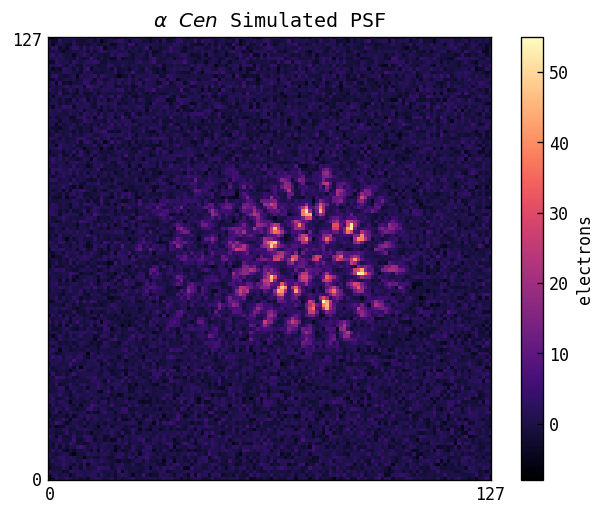

In [22]:
obj = AlfCen(seed=0)
obj.pa = 90

ideal = obj.get_PSF()
PSF = obj.add_noise(ideal)

# Second plot
fig, ax = plt.subplots()
c = ax.imshow(PSF, cmap='magma')
ax.set(title=r'$\alpha$ $Cen$ Simulated PSF', xticks=[0,PSF.shape[0]-1], yticks=[0,PSF.shape[1]-1])
fig.colorbar(c, ax=ax, label = 'electrons')
plt.show()